# ObsID : 0827211301, SRCNUM : 20, Instru : EPN
Not on Simbad. Previous observation of the source ObsID : 0945020137, SRCNUM : 21

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob

from astropy.io import fits
from astropy.stats import poisson_conf_interval

import stingray as st
from stingray import Lightcurve, AveragedPowerspectrum
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
from stingray.pulse.search import epoch_folding_search, z_n_search
from stingray.gti import create_gti_mask
from stingray.pulse.search import search_best_peaks
from stingray.stats import fold_detection_level, z2_n_detection_level

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plt.rcParams['figure.figsize'] = [10,5]

## Light curve

In [44]:
def periodicity(file, gtis, max_gti):
    hdul = fits.open(file)
    print()
    print(color.BOLD +file+ color.END)
    hdul.info()
    
    rate_data = hdul[1].columns
    print()
    print(rate_data)
        
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    error = hdul[1].data.field('ERROR')
    backrate = hdul[1].data.field('BACKV')
    
    lcs = []
    backlcs = []
    lcs.append(Lightcurve(time, rate, error, gti=gtis, input_counts=False))
    backlcs.append(Lightcurve(time, backrate, error, gti=gtis, input_counts=False))
    
    for i in range(len(lcs)):
        plt.xlabel('Time (s)')
        plt.ylabel('Countrate (/s)')
        plt.plot(lcs[i].time, lcs[i].countrate, color='steelblue', lw=1, ds='steps-mid', label='Source')
        plt.plot(backlcs[i].time, backlcs[i].countrate, color='firebrick',lw=1, ls='--', ds='steps-mid', label='Background')
        plt.title(f'{file}')
        plt.legend(loc='upper right')
        plt.grid()
        for j in range(len(lcs[i].gti)-1):
            plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
        plt.show()

    avg_ps = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
    
    def linear_fit(log_freq, slope, intercept):
        return slope * log_freq + intercept

    valid = (avg_ps.freq > 0) & (avg_ps.power > 0)
    log_freq = np.log10(avg_ps.freq[valid])
    log_power = np.log10(avg_ps.power[valid])

    params, _ = curve_fit(linear_fit, log_freq, log_power)
    slope, intercept = params
    
    # Ligne ajustée
    fitted_line = 10**(slope * log_freq + intercept)
    
    plt.plot(avg_ps.freq, avg_ps.power, lw=1, color='steelblue', label="Averaged PSD")
    plt.loglog(10**log_freq, fitted_line, color='firebrick', linestyle='--', lw=1, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (/rms)")
    plt.title(f'{file}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [40]:
def periodicity_rebin(file, gtis, max_gti, dt_rebin):
    hdul = fits.open(file)
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    error = hdul[1].data.field('ERROR')
    backrate = hdul[1].data.field('BACKV')
    
    lcs = []
    lc = Lightcurve(time, rate, error, gti=gtis, input_counts=False)
    lcs.append(lc.rebin(dt_rebin))
    
    for i in range(len(lcs)):
        plt.xlabel('Time (s)')
        plt.ylabel('Countrate (/s)')
        plt.plot(lcs[i].time, lcs[i].countrate, color='steelblue', lw=1, ds='steps-mid', label='Source')
        plt.title(f'Time bin size : {dt_rebin}s')
        plt.legend(loc='upper right')
        plt.grid()
        for j in range(len(lcs[i].gti)-1):
            plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
        plt.show()

    avg_ps = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
    
    def linear_fit(log_freq, slope, intercept):
        return slope * log_freq + intercept

    valid = (avg_ps.freq > 0) & (avg_ps.power > 0)
    log_freq = np.log10(avg_ps.freq[valid])
    log_power = np.log10(avg_ps.power[valid])

    params, _ = curve_fit(linear_fit, log_freq, log_power)
    slope, intercept = params
    
    # Ligne ajustée
    fitted_line = 10**(slope * log_freq + intercept)
    
    plt.plot(avg_ps.freq, avg_ps.power, lw=1, color='steelblue', label="Averaged PSD")
    plt.loglog(10**log_freq, fitted_line, color='firebrick', linestyle='--', lw=1, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (/rms)")
    plt.title(f'Time bin size : {dt_rebin}s')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [46]:
def gtis(file):
    hdul = fits.open(file)
    gtis = []
    max_gti = 0
    for i in hdul[2].data:
        gtis.append([i[0],i[1]])
        if i[1] - i[0] > max_gti:
            max_gti = i[1] - i[0]
    print("max gti :", max_gti)
    return gtis, max_gti

max gti : 16696.56000006199

P0827211301PNX000SRCTSR8014.FTZ
Filename: P0827211301PNX000SRCTSR8014.FTZ
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   ()      
  1  RATE          1 BinTableHDU    168   20385R x 28C   [D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 4A, D]   
  2  SRC_GTIS      1 BinTableHDU     28   11R x 2C   [D, D]   
  3  BKG_GTIS      1 BinTableHDU     28   11R x 2C   [D, D]   
  4  REGION_SRC    1 BinTableHDU     23   1R x 4C   [16A, E, E, E]   
  5  REGION_BKG    1 BinTableHDU     23   1R x 4C   [16A, E, E, E]   

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count s-1'
    name = 'ERROR'; format = 'E'; unit = 'count s-1'
    name = 'FRACEXP'; format = 'E'; unit = 'fraction'
    name = 'BACKV'; format = 'E'; unit = 'count s-1'
    name = 'BACKE'; format = 'E'; unit = 'count s-1'
    name = 'RATE1'; format = 'E'; unit = 'count s-1'


/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


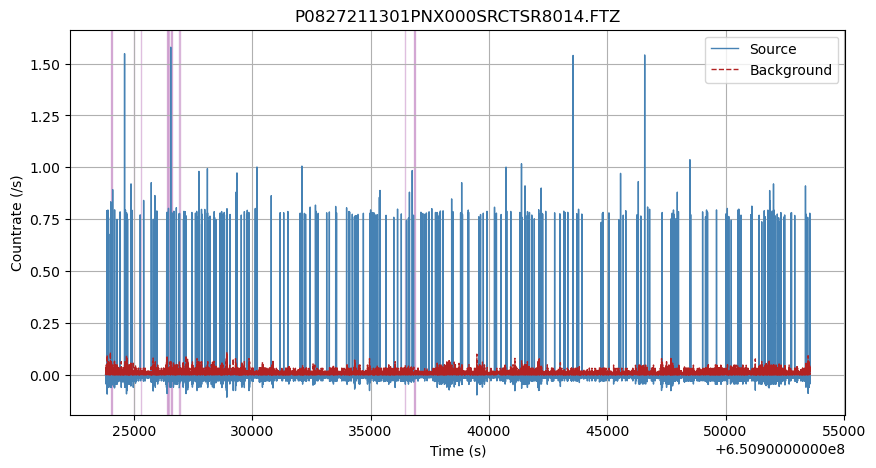

/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:388: RuntimeWarning: invalid value encountered in multiply
  counts = self._countrate * self.dt


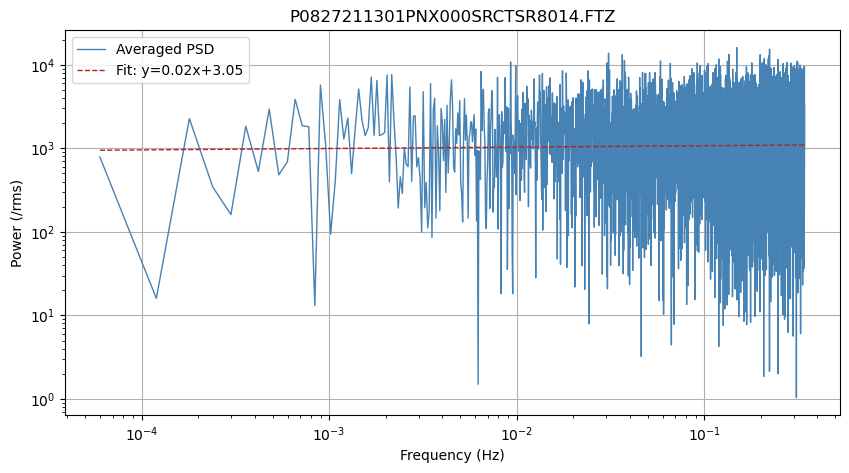

In [47]:
lc_fname = glob.glob("P*PNX*SRCTSR*.FTZ")
gtis, max_gti = gtis(lc_fname[0])
periodicity(lc_fname[0], gtis, max_gti)

### Time bin size = 10s

/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:408: RuntimeWarning: invalid value encountered in multiply
  counts_err = self._countrate_err * self.dt
/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:388: RuntimeWarning: invalid value encountered in multiply
  counts = self._countrate * self.dt


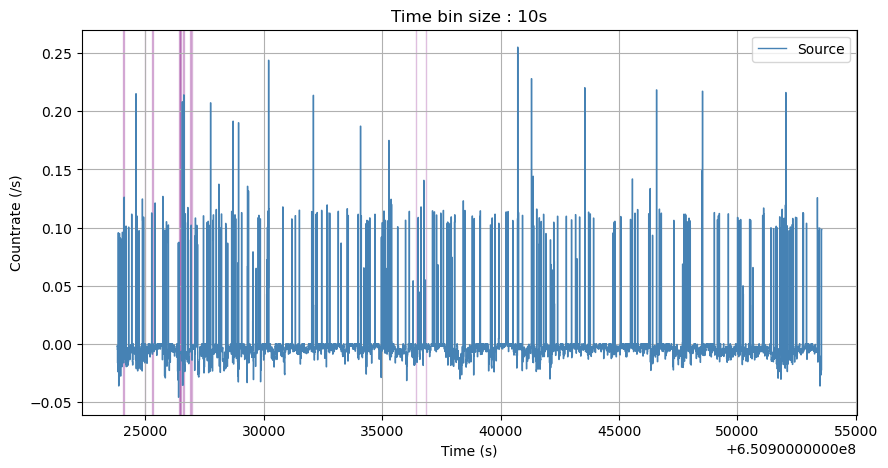

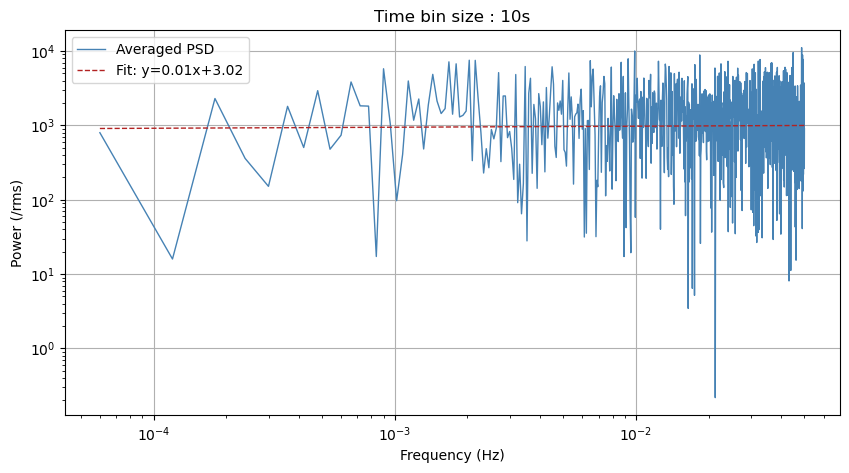

In [48]:
periodicity_rebin(lc_fname[0], gtis, max_gti, 10)

### Time bin size = 50s

/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:408: RuntimeWarning: invalid value encountered in multiply
  counts_err = self._countrate_err * self.dt
/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:388: RuntimeWarning: invalid value encountered in multiply
  counts = self._countrate * self.dt


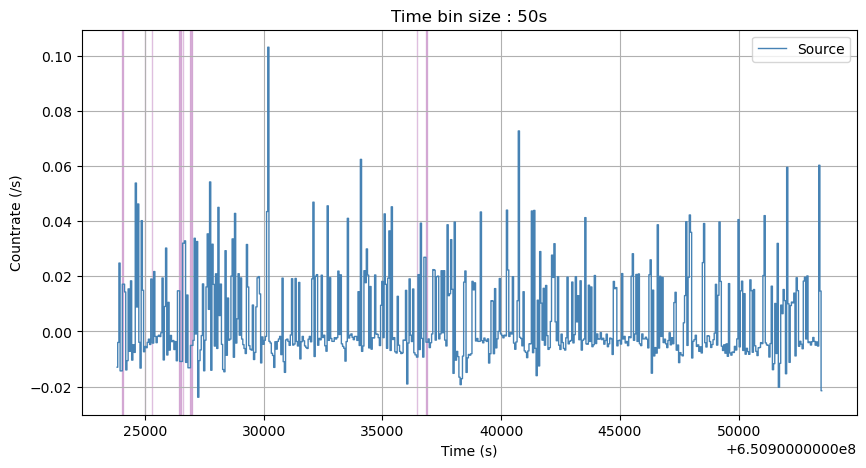

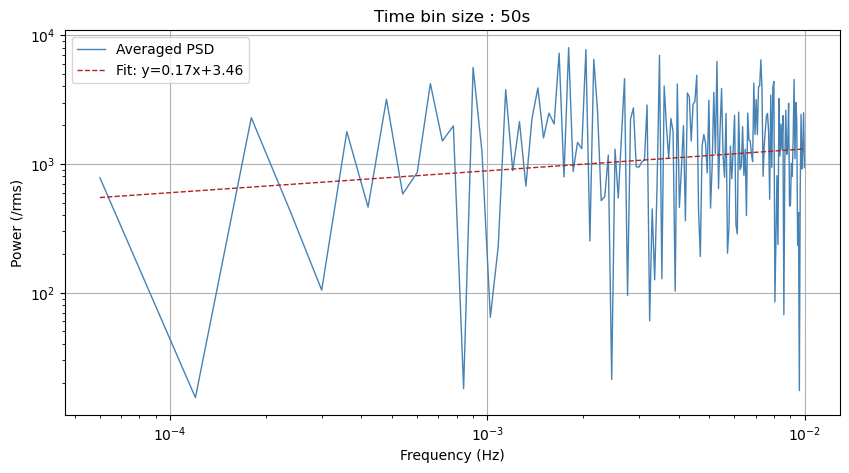

In [7]:
periodicity_rebin(lc_fname[0], gtis, max_gti, 50)

### Time bin size = 200s

/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:408: RuntimeWarning: invalid value encountered in multiply
  counts_err = self._countrate_err * self.dt
/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:388: RuntimeWarning: invalid value encountered in multiply
  counts = self._countrate * self.dt


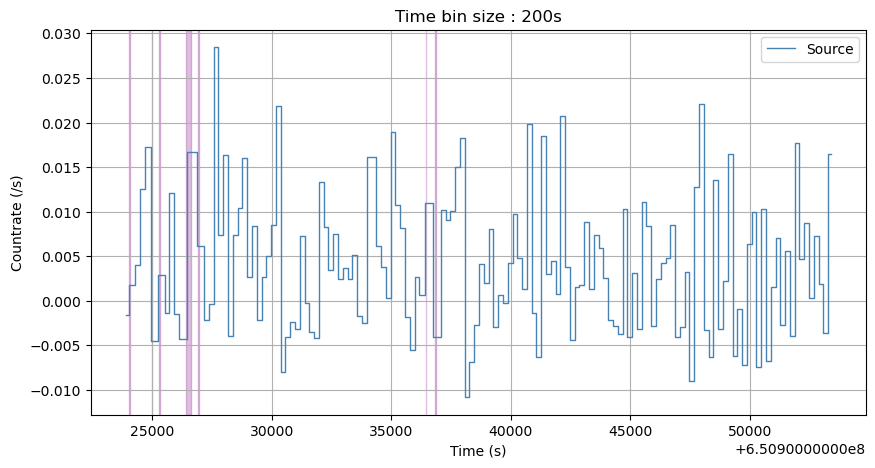

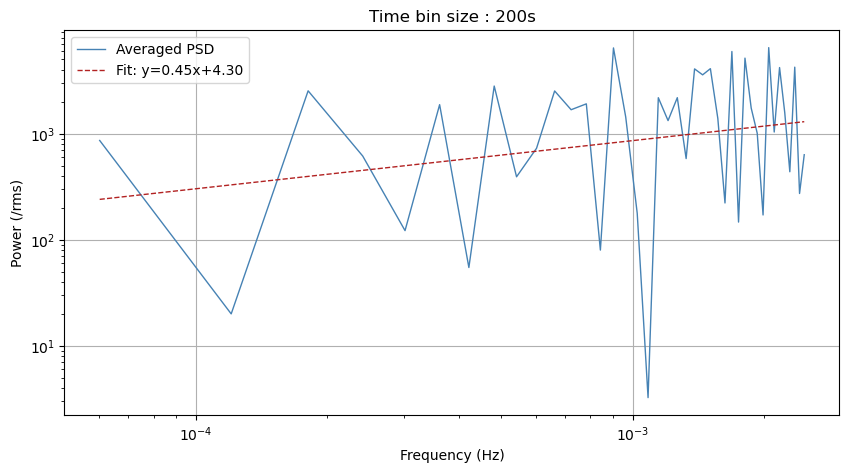

In [8]:
periodicity_rebin(lc_fname[0], gtis, max_gti, 200)

### Time bin size = 500s

/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:408: RuntimeWarning: invalid value encountered in multiply
  counts_err = self._countrate_err * self.dt
/home/celia/.local/lib/python3.10/site-packages/stingray/lightcurve.py:388: RuntimeWarning: invalid value encountered in multiply
  counts = self._countrate * self.dt


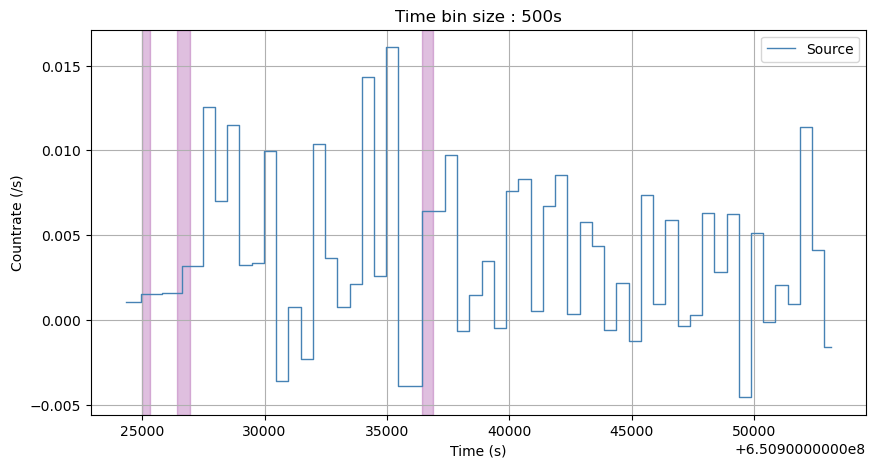

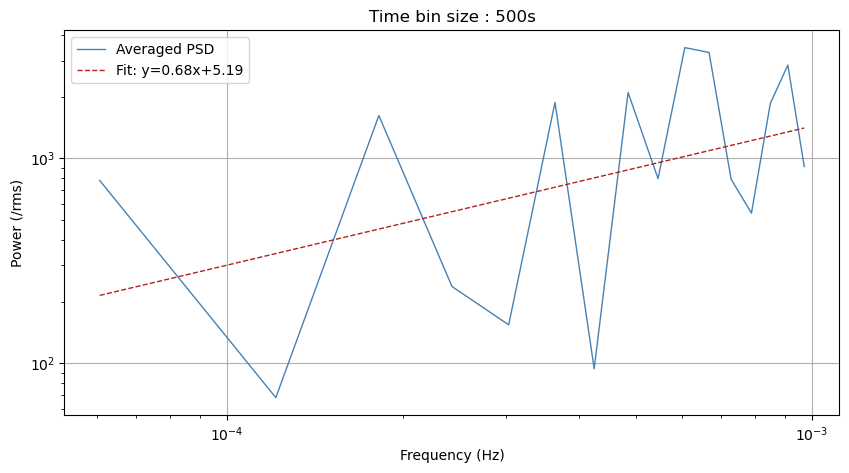

In [9]:
periodicity_rebin(lc_fname[0], gtis, max_gti, 500)

## Event list

In [10]:
evt_names = glob.glob("*source_events.fits")

source_events = st.EventList.read(evt_names[0],fmt_='hea',skip_checks=True)
source_events.gti = gtis
gti_mask = create_gti_mask(source_events.time,gtis)
clean_times = source_events.time[gti_mask]
clean_events = st.EventList(clean_times, pi=source_events.pi[gti_mask])
clean_events.filter_energy_range([200,12000],inplace=True,use_pi=True)

/home/celia/.local/lib/python3.10/site-packages/stingray/base.py:1226: UserWarning: The time array is not sorted. Sorting it now.
  warnings.warn("The time array is not sorted. Sorting it now.")


``st.EventList.read`` permet la lecture du fichier source_events.fits au format Heasoft/fits (fmt_='hea'). La sortie *source_events* est une liste d'événements X-ray, incluant les temps d'arrivée et les énergies des photons.

``source_events.gti`` définit la fenêtre de temps valide (GTI, Good Time Interval) pour les événements.

``create_gti_mask()`` génère un masque booléen basé sur les GTIs. La fonction retourne le tableau booléen *gti_mask*.

``clean_times`` filtre les temps des photons pour ne garder que ceux dans les GTIs.

``clean_events`` crée une nouvelle liste d'événements filtrés (*clean_events*), en gardant les énergies associées (pi = Pulse Invariant, un indicateur d’énergie).

In [19]:
obs_length = max(source_events.time) - min(source_events.time)
print("Lenght of the observation :", obs_length)
print()

df_min = 1/obs_length
oversampling=15
df = df_min / oversampling

frequencies = np.arange(2*df_min, 5, df)
print("frequencies :", frequencies)

Lenght of the observation : 29741.73490548134

frequencies : [6.72455728e-05 6.94870919e-05 7.17286110e-05 ... 4.99999525e+00
 4.99999749e+00 4.99999974e+00]


``max(source_events.time)`` trouve le temps d'arrivée du dernier photon enregistré et ``min(source_events.time)`` trouve le temps d'arrivée du premier photon enregistré. Donc, *obs_length* correspond à la durée totale de l'observation. Ce calcul est important pour déterminer la résolution en fréquence dans une analyse de Fourier.

*``df_min = 1/obs_length``* définit la résolution minimale en fréquence (fréquence fondamentale). C'est la plus petite fréquence accessible par l'analyse.

*``oversampling = 15``* définit un facteur de sur-échantillonnage qui permet une meilleure interpolation du spectre en fréquence et évite des pertes d'information.

*``df = df_min / oversampling``* réduit l'intervalle entre deux fréquences consécutives, augmentant ainsi la densité des points dans le spectre de fréquence.

``np.arange(2*df_min, 5, df)`` génère un tableau de fréquences allant de 2*df_min à 5 Hz, avec un pas de df. 2*df_min : Évite d'inclure la fréquence trop basse qui peut être bruitée et 5 Hz fixe une fréquence maximale d'analyse. Ce vecteur sera typiquement utilisé pour calculer un périodogramme ou une densité spectrale de puissance (PSD).

In [12]:
freq, efstat = epoch_folding_search(clean_events.time, frequencies, nbin=32, gti=gtis)
freq, zstat = z_n_search(clean_events.time, frequencies, nbin=32, nharm=1, gti=gtis)

``epoch_folding_search()`` applique la méthode du pliage en phase (Epoch Folding) pour rechercher une périodicité. Avec *clean_events.time* liste des temps d'arrivée des photons, *frequencies* le tableau des fréquences testées calculées précedement,  *nbin=32* qui divise chaque période en 32 bins de phase (permet d'améliorer la résolution temporelle dans le profil de phase) et *gti=gtis* utilise les Good Time Intervals (GTI) pour éviter les périodes où l'observation est interrompue.

**Principe de Epoch Folding :** On suppose une période candidate 𝑃=1/𝑓. On "plie" les événements sur cette période et on analyse la forme du profil de phase. Si une fréquence donnée correspond à un signal périodique, le profil de phase montre une modulation significative, et la statistique est plus élevée. Idéal pour les sources X, pulsars, QPOs avec des profils de phase connus.

``z_n_search()`` : Applique le test Z_n^2 pour rechercher une périodicité. Avec *nharm=1* le nombre d'harmonique. On utilise 1 seule harmonique (utile pour détecter des signaux sinusoidaux simples, mais on peut tester plus d’harmoniques pour des formes plus complexes).

**Principe du Zn test :** Basé sur la décomposition harmonique des événements dans un espace de phase. Plus sensible aux signaux sinusoïdaux purs. Détecte des périodes via une somme pondérée des phases des événements, en considérant un nombre d’harmoniques nharm (ici 1). Plus efficace que Epoch Folding pour certains signaux. Idéal pour les signaux sinusoïdaux purs (pulsars, étoiles binaires).

In [13]:
ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(32, epsilon=0.001, ntrial=len(freq))

``ntrial`` est le nombre d'essais indépendants (nombre de fréquences testées).

``z_detlev`` est le seuil pour considérer un pic dans Zn2 comme significatif.

``ef_detlev`` est le seuil pour considérer un pic dans Epoch Folding comme significatif.

In [58]:
cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

print(f"Number of significant frequencies detected by Epoch folding : {len(cand_freqs_ef)}.")
for i in range(len(cand_freqs_ef)):
    print("cand_freqs_ef :", cand_freqs_ef[i], "cand_stat_ef :", cand_stat_ef[i])

print()
print(f"Number of significant frequencies detected by Zn test : {len(cand_freqs_z)}.")
for i in range(len(cand_freqs_z)):
    print("cand_freqs_z :", cand_freqs_z[i], "cand_stat_z :", cand_stat_z[i])

Number of significant frequencies detected by Epoch folding : 10.
cand_freqs_ef : 8.517772555582985e-05 cand_stat_ef : 294.5261382799325
cand_freqs_ef : 0.0001165589928658725 cand_stat_ef : 135.55143338954466
cand_freqs_ef : 0.0001434572219887662 cand_stat_ef : 128.64418212478918
cand_freqs_ef : 0.00012776658833374486 cand_stat_ef : 128.48229342327147
cand_freqs_ef : 0.0005088248342414056 cand_stat_ef : 112.50927487352442
cand_freqs_ef : 0.00016811393201808544 cand_stat_ef : 112.34738617200671
cand_freqs_ef : 0.00028691444397753257 cand_stat_ef : 109.59527824620571
cand_freqs_ef : 0.00017708000839238334 cand_stat_ef : 108.30016863406406
cand_freqs_ef : 0.00013224962652089384 cand_stat_ef : 107.92242833052275
cand_freqs_ef : 0.00013897418380161725 cand_stat_ef : 106.30354131534568

Number of significant frequencies detected by Zn test : 2.
cand_freqs_z : 8.293620646225538e-05 cand_stat_z : 185.39713542491415
cand_freqs_z : 0.0005110663533349801 cand_stat_z : 44.48117254636951


``search_best_peaks`` permet de trouver les fréquences candidates présentant des pics significatifs dans la statistique Epoch Folding (ou Zn2 test), avec *freq* la liste des fréquences analysées, *efstat* les valeurs de la statistique Epoch Folding (ou *zstat* pour Zn2 test) pour chaque fréquence et *ef_detlev* le seuil de détection pour Epoch Folding (ou *z_detlev* pour Zn2 test).

*cand_freqs_ef* et *cand_freqs_z* liste des fréquences où un signal significatif est détecté. *cand_stat_ef* et *cand_stat_z* liste les valeurs des statistiques correspondantes.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


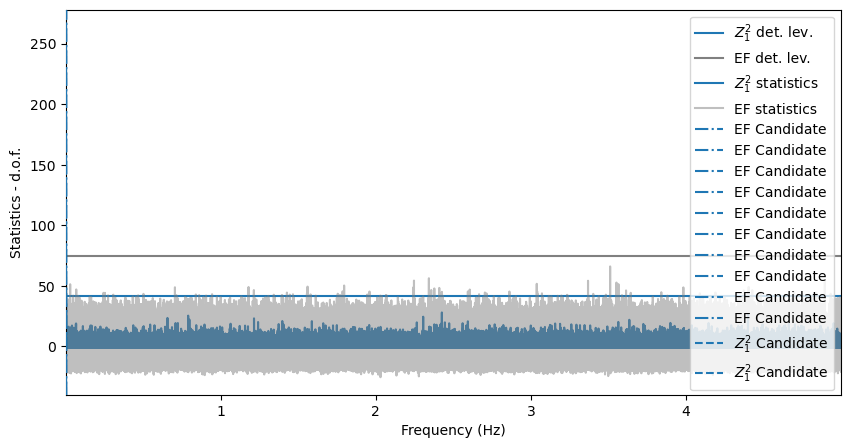

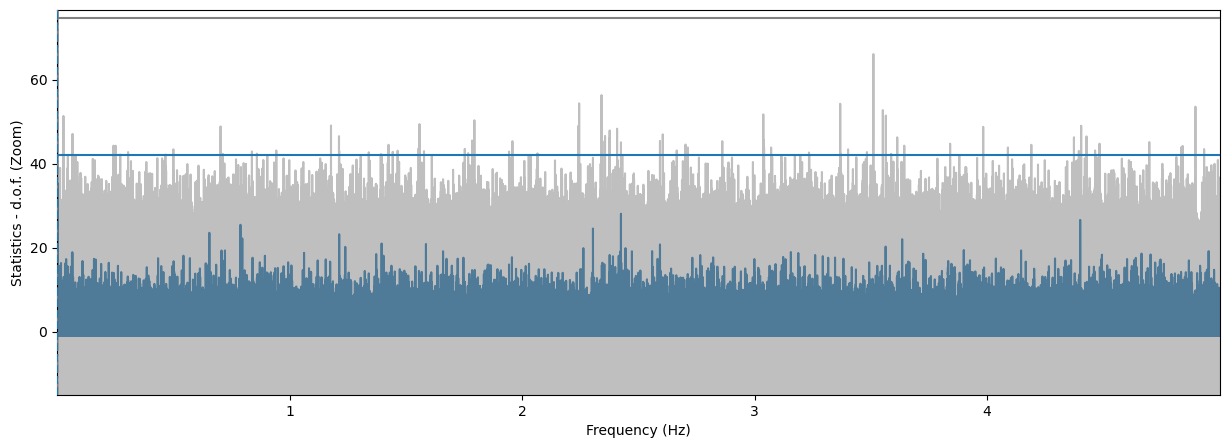

In [15]:
nharm=1
nbin=32

plt.figure()
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', zorder=10)
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray', zorder=10)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', color='gray', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, ef_detlev - nbin + 3])
_ = plt.xlim([frequencies[0], frequencies[-1]])

Period (Epoch folding) : 11740.158515321575
Period (Zn test) : 12057.460096816754


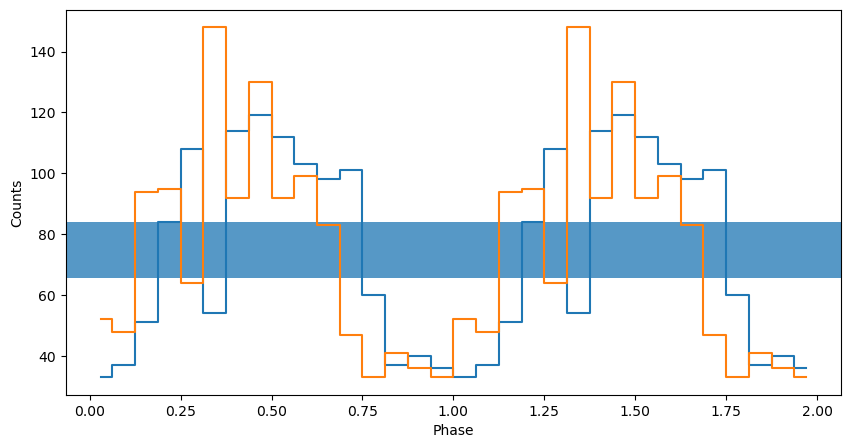

In [31]:
f0_ef = 8.517772555582985e-05
f0_z = 8.293620646225538e-05

P_ef = 1 / f0_ef
P_z = 1 / f0_z
print("Period (Epoch folding) :", P_ef)
print("Period (Zn test) :", P_z)

ph_ef, profile_ef, profile_err_ef = fold_events(clean_events.time, f0_ef)
_ = plot_profile(ph_ef,profile_ef) # Blue

ph_z, profile_z, profile_err_z = fold_events(clean_events.time, f0_z)
_ = plot_profile(ph_z,profile_z) # Orange

profile_err_ef
profile_err_z

ph_out_ef = np.concatenate((ph_ef,ph_ef+1))
profile_out_ef = np.concatenate((profile_ef,profile_ef))
prof_err_out_ef = np.concatenate((profile_err_ef,profile_err_ef))

ph_out_z = np.concatenate((ph_z,ph_z+1))
profile_out_z = np.concatenate((profile_z,profile_z))
prof_err_out_z = np.concatenate((profile_err_z,profile_err_z))

np.savetxt('ObsID0827211301_SRCNUM20_EPN_pulse_profile_ef.csv',(ph_out_ef, profile_out_ef,prof_err_out_ef),delimiter=',')
np.savetxt('ObsID0827211301_SRCNUM20_EPN_pulse_profile_z.csv',(ph_out_z, profile_out_z,prof_err_out_z),delimiter=',')

In [59]:
err_low_ef, err_high_ef = poisson_conf_interval(np.mean(profile_ef), interval="frequentist-confidence", sigma=1)
print(color.BOLD +"Epoch folding :"+ color.END)
print(f"Mean profile : {np.mean(profile_ef)}, err_low : {err_low_ef}, err_high : {err_high_ef}")
err_low_ef, err_high_ef = poisson_conf_interval(np.mean(profile_ef), interval="frequentist-confidence", sigma=3)
print(f"Mean profile : {np.mean(profile_ef)}, err_low : {err_low_ef}, err_high : {err_high_ef}")
print()

err_low_z, err_high_z = poisson_conf_interval(np.mean(profile_z), interval="frequentist-confidence", sigma=1)
print(color.BOLD +"Zn test :"+ color.END)
print(f"Mean profile : {np.mean(profile_z)}, err_low : {err_low_z}, err_high : {err_high_z}")
err_low_z, err_high_z = poisson_conf_interval(np.mean(profile_z), interval="frequentist-confidence", sigma=3)
print(f"Mean profile : {np.mean(profile_z)}, err_low : {err_low_z}, err_high : {err_high_z}")

Epoch folding :
Mean profile : 74.1875, err_low : 65.59374032550174, err_high : 83.83944384389767
Mean profile : 74.1875, err_low : 50.990011335402414, err_high : 103.88213606414806

Zn test :
Mean profile : 74.1875, err_low : 65.59374032550174, err_high : 83.83944384389767
Mean profile : 74.1875, err_low : 50.990011335402414, err_high : 103.88213606414806
